# Functional Tensor Train (fTT) approximation using the ALS algorithm

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [2]:
!pip install git+https://github.com/piterbarg/altnnpub

  Cloning https://github.com/piterbarg/altnnpub to /tmp/pip-req-build-l1rj83ev
  Running command git clone --filter=blob:none --quiet https://github.com/piterbarg/altnnpub /tmp/pip-req-build-l1rj83ev
  Resolved https://github.com/piterbarg/altnnpub to commit af3ee937abbd7660ee6259474250089124fa327e
  Preparing metadata (setup.py) ... done
  Created wheel for altnnpub: filename=altnnpub-0.0.1-py3-none-any.whl size=49887 sha256=f81aee5e54f12a9fa0d177a13ee7929edcf66fd0cc5b29acede11a73f7f24778
  Stored in directory: /tmp/pip-ephem-wheel-cache-t7nru7o7/wheels/ee/5a/6e/5d9a5c00e3da5e0ff3c467d9b75c690bd8fd327ec5fa6a581a
Successfully built altnnpub


In [3]:
import time
import numpy as np
import pandas as pd
from matplotlib import cm
from tensorflow import keras
import matplotlib.pyplot as plt

# our stuff
from nnu import gss_kernels as ssk
from nnu import ftt_regression as ftt
from nnu import points_generator as pgen
from nnu import gss_report_generator as ssrg


## Create the function to fit and sample it randomly

In [4]:
ndim = 5 # 2 # 3 # 5
sim_range = 4

nx = 10000
input_seed = 1917
xs = pgen.generate_points(
    sim_range, nx, ndim, 'random', seed=input_seed)[0]

input_f_spec = 'laplace_1' # 'midrank_0'
genres = ssrg.generate_inputs_and_nodes(
    ndim=ndim,
    nsamples=nx,
    nnodes=nx,
    input_f_spec=input_f_spec,
    input_seed=input_seed,
    nsr_stretch=1.0,
    sim_range = sim_range,
    )
func = genres[-1]
ys = func(xs)

## Create (1D) nodes, same for each dimension

In [5]:
nnodes = 2*int(pow(nx, 1.0/ndim))
kernel = 'invquad'
scale_mult = 4.0
stretch = 1.1

global_scale = 2*sim_range*stretch / nnodes
knl_f = ssk.global_kernel_dict(global_scale * scale_mult)[kernel]
nodes = np.linspace(-sim_range*stretch, sim_range*stretch, nnodes, endpoint=True)

## Specify the TT ranks

In [10]:
tt_flat_rank = 4
tt_ranks = [1] + [tt_flat_rank]*(ndim-1) + [1]

## Perform fitting via ALS

In [14]:
# How many iterations. Here hard-coded for simplicity
n_iter = 10

start_time = time.time()
bf_vals = ftt.basis_function_values(xs, nodes, knl_f)
np.random.seed(input_seed)
init_val = None

tt_cores = ftt.init_tt(tt_ranks, nnodes, init_val=init_val)


for iter in range(n_iter):
    for d in range(ndim):
        tt_cores, ys_fit = ftt.solve_for_dimension(
            d=d, tt_cores=tt_cores, bf_vals=bf_vals, ys=ys)

    r2 = 1 - np.linalg.norm(ys_fit - ys)/np.linalg.norm(ys)
    print(f'iter = {iter} r2 = {r2:.4f}')
end_time = time.time()
print(f'time elapsed = {end_time - start_time:0.2f} sec')

iter = 0 r2 = 0.7320
iter = 1 r2 = 0.9060
iter = 2 r2 = 0.9518
iter = 3 r2 = 0.9621
iter = 4 r2 = 0.9716
iter = 5 r2 = 0.9741
iter = 6 r2 = 0.9747
iter = 7 r2 = 0.9749
iter = 8 r2 = 0.9749
iter = 9 r2 = 0.9750
time elapsed = 27.43 sec


## Explore the results

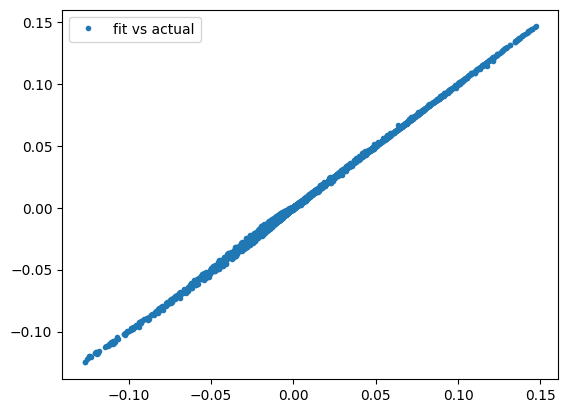

In [15]:
%matplotlib inline
plt.plot(ys, ys_fit, '.', label = 'fit vs actual')
plt.legend(loc = 'best')
plt.show()


## Apply the model to a new (test) set and see the results

In [16]:
test_seed = input_seed * 2
x_test = pgen.generate_points(
    sim_range, nx, ndim, 'random', seed=test_seed)[0]
y_test_act = func(x_test)
y_test_fit = ftt.predict(x_test, tt_cores, knl_f, nodes)
test_mse = np.linalg.norm(y_test_fit - y_test_act)/np.linalg.norm(y_test_act)
print(f'learn mse = {1-r2:.4f}')
print(f'test mse = {test_mse:.4f}')

learn mse = 0.0250
test mse = 0.0332


<ipython-input-17-8786b53eb4f6>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs[:,0],xs[:,1],ys,  # c=ys,
<ipython-input-17-8786b53eb4f6>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs[:,0],xs[:,1],ys_fit,  # c=ys,


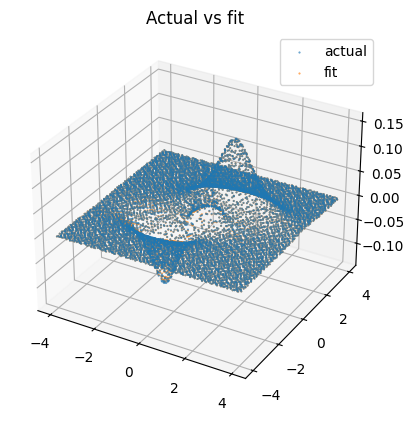

In [17]:
# %matplotlib auto
%matplotlib inline
f1 = plt.figure()
ax = f1.add_subplot(projection='3d')

ax.scatter(xs[:,0],xs[:,1],ys,  # c=ys,
           cmap=cm.coolwarm, marker='.', alpha = 0.75, s=1, label = 'actual')
ax.scatter(xs[:,0],xs[:,1],ys_fit,  # c=ys,
           cmap=cm.coolwarm, marker='.', alpha = 0.75, s=1, label = 'fit')
plt.title('Actual vs fit')
plt.legend(loc = 'best')
plt.show()

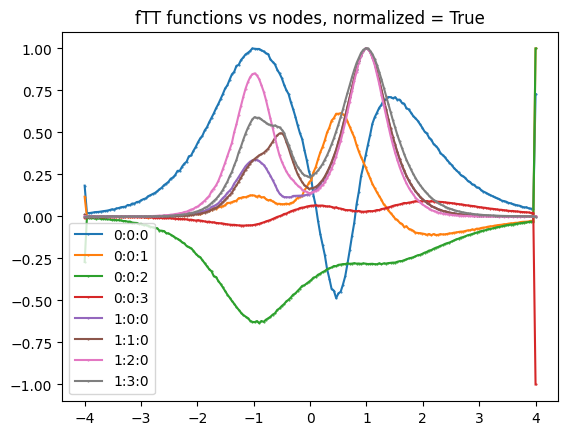

In [18]:
# %matplotlib auto
%matplotlib inline
normalize = True
plot_nodes = np.linspace(-sim_range, sim_range, nnodes, endpoint=True)
nodes_nd = np.repeat(plot_nodes.reshape(-1,1),ndim,axis=1)
for d in range(ndim):
    for i in range(tt_cores[d].shape[0]):
        for j in range(tt_cores[d].shape[2]):
            f = ftt.get_function(d, i, j, tt_cores, knl_f, nodes)
            label = f'{d}:{i}:{j}'
            fs = f(nodes_nd)
            if normalize:
                fs = fs/np.max(np.abs(fs))
            plt.plot(plot_nodes, fs, '.-',
                        markersize=1, label=label)
plt.legend(loc='best')
plt.title(f'fTT functions vs nodes, normalized = {normalize}')
plt.show()
